## Calculating return period for cyclones in Madagascar



We're looking to calculate the return period for cyclones of a given threshold speed in Madagascar.
- An overall return period across the country

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
from shapely.geometry import LineString
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [3]:
AA_DATA_DIR = os.getenv("AA_DATA_DIR")

## Data loading and preparation

https://en.wikipedia.org/wiki/Tropical_cyclone_scales#South-West_Indian_Ocean


In [4]:
adm0_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "mdg"
    / "cod_ab"
    / "mdg_admbnda_adm0_BNGRC_OCHA_20181031.shp"
)
gdf_adm0 = gpd.read_file(adm0_path)

ibtracs_path = adm1_path = (
    Path(AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
)
points_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)

gdf_points = gpd.read_file(points_path)

In [97]:
buffer = True
if buffer:
    # Create buffer around gdf_adm0 with the given distance
    # Reproject to a CRS that uses meters (e.g., EPSG:3857)
    gdf_adm0_buffer = gdf_adm0.to_crs(epsg=3857)

    # Apply the buffer of 100 km (100,000 meters)
    gdf_adm0_buffer["geometry"] = gdf_adm0_buffer.geometry.buffer(
        100 * 1000
    )  # 100 km = 100,000 meters

    # Reproject back to the original CRS
    gdf_adm0_buffer = gdf_adm0_buffer.to_crs(gdf_adm0.crs)
else:
    gdf_adm0_buffer = gdf_adm0.copy()

In [98]:
gdf_points_sel = gpd.sjoin(
    gdf_points, gdf_adm0_buffer, how="inner", predicate="intersects"
)
gdf_points_sel_ = gdf_points_sel.sort_values("ISO_TIME")

<Axes: >

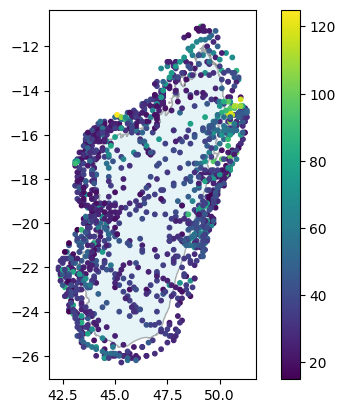

In [99]:
ax = gdf_adm0.plot(color="lightblue", edgecolor="black", alpha=0.3)
gdf_points_sel_.plot(ax=ax, column="REU_WIND", markersize=10, legend=True)

## Return period calculation


In [100]:
# combining US Wind and REUnion for those with no wind speed
gdf_points_sel_["REU_USA_WIND"] = gdf_points_sel_["REU_WIND"].fillna(
    gdf_points_sel_["USA_WIND"] * 0.88
)

In [101]:
df = gdf_points_sel_[
    gdf_points_sel_["ISO_TIME"].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year
    )
    >= 1998
]
df["NAME"].unique()

array(['UNNAMED', 'BELTANE', 'DAVINA', 'ASTRIDE', 'ELINE:LEONE', 'GLORIA',
       'HUDAH', 'DERA', 'CYPRIEN', 'GUILLAUME', 'HARY', 'KESINY', 'ATANG',
       'DELFINA', 'FARI', 'JAPHET', 'MANOU', 'CELA', 'ELITA', 'GAFILO',
       'ERNEST', 'FELAPI', 'BOLOETSE', 'BONDO', 'CLOVIS', 'ENOK',
       'INDLALA', 'JAYA', 'FAME', 'IVAN', 'JOKWE', 'ASMA', 'ERIC',
       'FANELE', 'JADE', 'BONGANI', 'DAVID', 'FAMI', 'HUBERT', 'JOEL',
       'BINGIZA', 'CHANDA', 'DANDO', 'GIOVANNA', 'IRINA', 'ANAIS',
       'HARUNA', 'DELIWE', 'HELLEN', 'CHEDZA', 'FUNDI', 'HALIBA', 'ABELA',
       'ENAWO', 'AVA', 'ELIAKIM', 'IDAI', 'BELNA', 'DIANE', 'FRANCISCO',
       'HEROLD', 'CHALANE', 'ELOISE', 'IMAN', 'ANA', 'BATSIRAI', 'DUMAKO',
       'EMNATI', 'GOMBE', 'JASMINE', 'CHENESO', 'FREDDY', 'ALVARO',
       'GAMANE'], dtype=object)

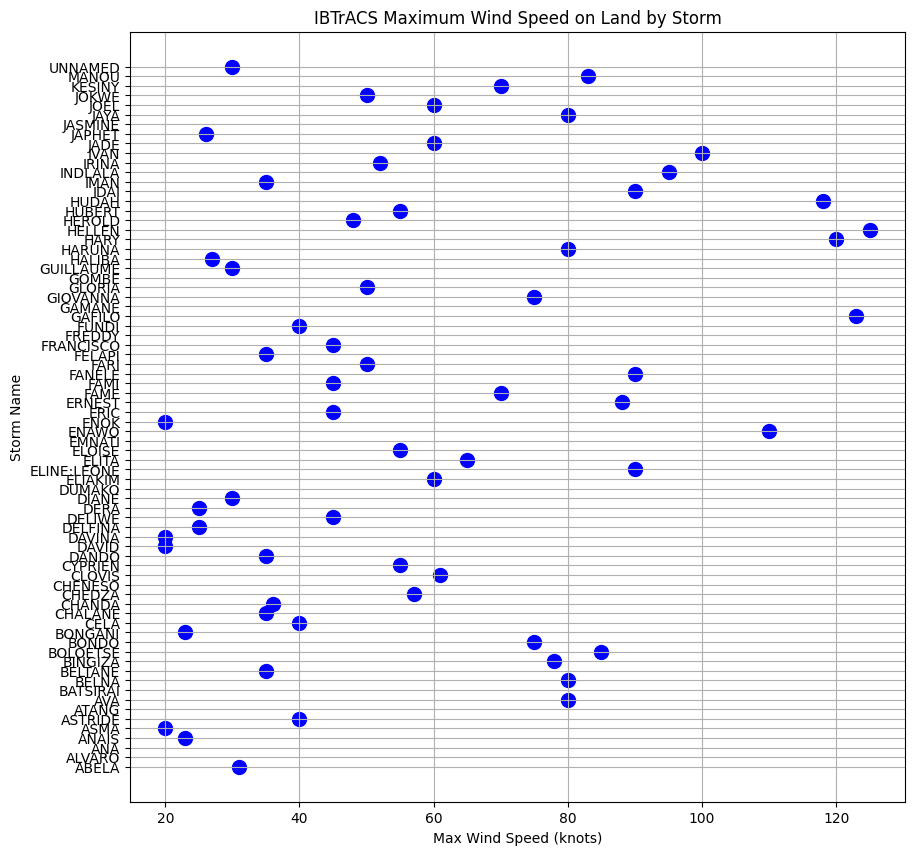

In [102]:
max_values = df.groupby("NAME")["REU_WIND"].max().reset_index()

# Step 3: Plot the maximum values as points for each category
plt.figure(figsize=(10, 10))
plt.scatter(
    max_values["REU_WIND"],
    max_values["NAME"],
    color="blue",
    s=100,
    label="Max Wind Speed",
)

# Adding labels and title
plt.ylabel("Storm Name")
plt.xlabel("Max Wind Speed (knots)")
plt.title("IBTrACS Maximum Wind Speed on Land by Storm")
plt.grid(True)
plt.show()

In [103]:
def calculate_storm_return_period(
    df, wind_speed_kmh_min, wind_speed_kmh_max, start_year
):
    # Conversion factor from kilometers per hour to knots
    kmh_to_knots = 1 / 1.852

    # Convert the given speed from km/h to knots
    min_speed_knots = wind_speed_kmh_min * kmh_to_knots
    max_speed_knots = wind_speed_kmh_max * kmh_to_knots

    # Extract the year from the 'ISO_TIME' column
    df["year"] = df["ISO_TIME"].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year
    )

    # Filter the DataFrame for records from the start year and with wind speed above the threshold
    df_filtered = df[
        (df["year"] >= start_year)
        & (df["REU_WIND"] >= min_speed_knots)
        & (df["REU_WIND"] <= max_speed_knots)
    ]

    # Count unique storms
    unique_storms = df_filtered["NAME"].nunique()

    # Calculate the total number of years in the filtered DataFrame
    yr_len = 2024 - start_year + 1

    # Calculate the combined return period
    combined_return_period = yr_len / unique_storms

    print(
        f"The combined return period of storms over {wind_speed_kmh_min}km/h is 1-in-{round(combined_return_period, 1)} years."
    )

In [104]:
# Scenario 2
calculate_storm_return_period(
    df=gdf_points_sel_,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=166,
    start_year=1980,
)

The combined return period of storms over 118km/h is 1-in-1.5 years.


In [105]:
# 118 km/h or higher
calculate_storm_return_period(
    df=gdf_points_sel_,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=300, # high upper bound for testing
    start_year=1980,
)

The combined return period of storms over 118km/h is 1-in-1.3 years.


In [106]:
# Scenario 3
calculate_storm_return_period(
    df=gdf_points_sel_,
    wind_speed_kmh_min=166,
    wind_speed_kmh_max=300, # high upper bound for testing
    start_year=1980,
)

The combined return period of storms over 166km/h is 1-in-3.5 years.


In [127]:
# Scenario 2 with 0km buffer OR Scenario 3
# Conversion factor from kilometers per hour to knots
kmh_to_knots = 1 / 1.852
start_year = 1980

# No buffer (118 km/h to 166 km/h)
min_speed_knots = 118 * kmh_to_knots
max_speed_knots = 166 * kmh_to_knots

# Extract the year from the 'ISO_TIME' column using .loc to avoid the warning
df.loc[:, "year"] = df["ISO_TIME"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year
)

# Filter the DataFrame for storms with wind speeds between 118 km/h and 166 km/h
df_filtered_nobuffer = df[
    (df["year"] >= start_year)
    & (df["REU_WIND"] >= min_speed_knots)
    & (df["REU_WIND"] < max_speed_knots)
]

# Get unique storms for the no-buffer case
unique_storms_nobuffer = df_filtered_nobuffer["NAME"].unique()

# 100km buffer for wind speeds above 166 km/h
min_speed_knots_buffer = 166 * kmh_to_knots

# Create a buffer of 100km around Madagascar
gdf_adm0_buffer = gdf_adm0.to_crs(epsg=3857)
gdf_adm0_buffer["geometry"] = gdf_adm0_buffer.geometry.buffer(
    100 * 1000
)  # 100 km buffer
gdf_adm0_buffer = gdf_adm0_buffer.to_crs(
    gdf_adm0.crs
)  # Reproject back to original CRS

# Filter the DataFrame for storms with wind speeds >= 166 km/h
df_filtered_buffer = df[
    (df["year"] >= start_year) & (df["REU_WIND"] >= min_speed_knots_buffer)
]

# Ensure the storm points are in the same CRS as the buffered Madagascar
df_filtered_buffer = df_filtered_buffer.set_geometry("geometry").set_crs(
    gdf_adm0.crs
)

# Perform spatial join to find storms within the 100 km buffer
df_filtered_buffer = gpd.sjoin(
    df_filtered_buffer, gdf_adm0_buffer, predicate="within", rsuffix="boundary"
)

# Get unique storms for the buffer case
unique_storms_buffer = df_filtered_buffer["NAME"].unique()

# Combine the two lists of unique storms and remove duplicates
combined_storms = list(
    set(np.append(unique_storms_nobuffer, unique_storms_buffer))
)

# Calculate the total number of years in the filtered DataFrame
yr_len = 2024 - start_year + 1

# Calculate the combined return period
combined_return_period = yr_len / len(combined_storms)

print(
    f"The combined return period of storms is 1-in-{round(combined_return_period, 1)} years."
)

The combined return period of storms is 1-in-2.0 years.


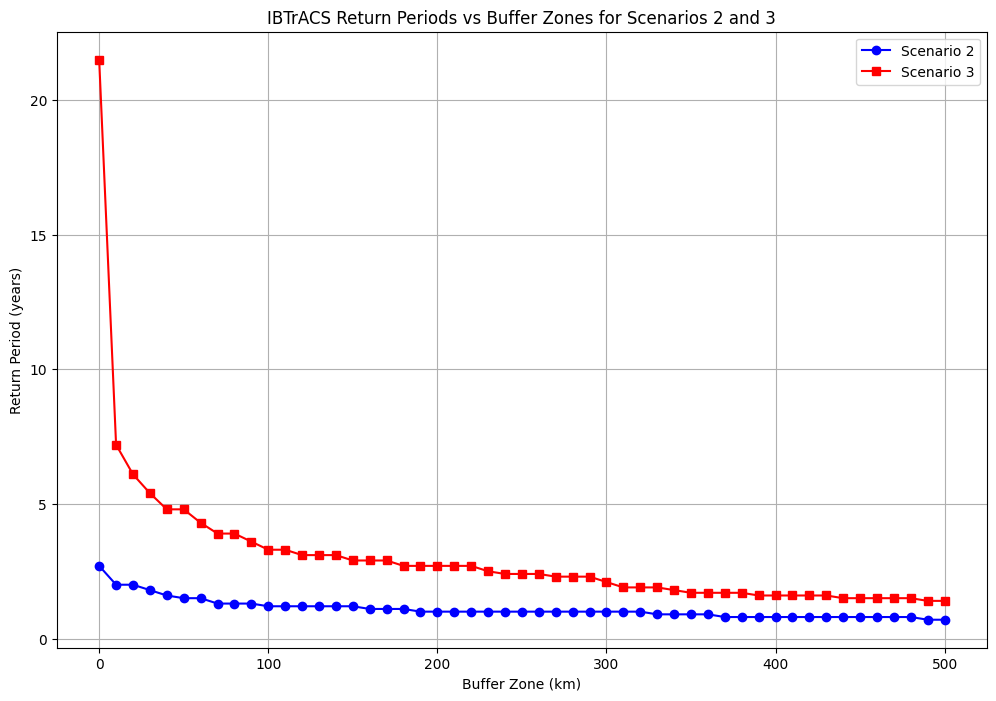

In [122]:
# Function to calculate the return period for a given wind speed threshold and buffer zone


def calculate_storm_return_period_buffer(
    df, gdf_adm0_buffer, wind_speed_kmh, start_year
):
    # Perform spatial join between storm points and buffer zone (gdf_adm0_buffer)
    df_sel = gpd.sjoin(
        df, gdf_adm0_buffer, how="inner", predicate="intersects"
    )
    df_sel_ = df_sel.sort_values("ISO_TIME")

    # Combining US Wind and Reunion wind for those with no wind speed data
    df_sel_["REU_USA_WIND"] = df_sel_["REU_WIND"].fillna(
        df_sel_["USA_WIND"] * 0.88
    )

    # Conversion factor from kilometers per hour to knots
    kmh_to_knots = 1 / 1.852

    # Convert the given speed from km/h to knots
    speed_knots = wind_speed_kmh * kmh_to_knots

    # Extract the year from the 'ISO_TIME' column
    df_sel_["year"] = df_sel_["ISO_TIME"].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year
    )

    # Filter the DataFrame for records from the start year and with wind speed above the threshold
    df_filtered = df_sel_[
        (df_sel_["year"] >= start_year) & (df_sel_["REU_WIND"] >= speed_knots)
    ]

    # Count unique storms
    unique_storms = df_filtered["NAME"].nunique()

    # Calculate the total number of years in the filtered DataFrame
    yr_len = 2022 - start_year + 1

    # Calculate the combined return period
    combined_return_period = yr_len / unique_storms
    return round(combined_return_period, 1)


# Buffers in kilometers
buffers = np.arange(0, 501, 10)

# Lists to store the return periods for 64 knots and 90 knots thresholds
return_periods_64_knots = []
return_periods_90_knots = []

# Iterate through buffers and calculate return periods for both thresholds
for buffer in buffers:
    # Create buffer around gdf_adm0 with the given distance
    # Reproject to a CRS that uses meters (e.g., EPSG:3857)
    gdf_adm0_buffer = gdf_adm0.to_crs(epsg=3857)

    # Apply the buffer of 100 km (100,000 meters)
    gdf_adm0_buffer["geometry"] = gdf_adm0_buffer.geometry.buffer(
        buffer * 1000
    )  # 100 km = 100,000 meters

    # Reproject back to the original CRS
    gdf_adm0_buffer = gdf_adm0_buffer.to_crs(gdf_adm0.crs)

    # Calculate return period for 64 knots threshold
    return_64_knots = calculate_storm_return_period_buffer(
        gdf_points, gdf_adm0_buffer, wind_speed_kmh=118, start_year=1980
    )  # 118.5 km/h = 64 knots

    # Calculate return period for 90 knots threshold
    return_90_knots = calculate_storm_return_period_buffer(
        gdf_points, gdf_adm0_buffer, wind_speed_kmh=166, start_year=1980
    )  # 166.7 km/h = 90 knots

    # Store the return periods
    return_periods_64_knots.append(return_64_knots)
    return_periods_90_knots.append(return_90_knots)

# Plotting the return periods for both 64 knots and 90 knots
plt.figure(figsize=(12, 8))
plt.plot(
    buffers,
    return_periods_64_knots,
    marker="o",
    label="Scenario 2",
    color="blue",
)
plt.plot(
    buffers,
    return_periods_90_knots,
    marker="s",
    label="Scenario 3",
    color="red",
)

plt.title("IBTrACS Return Periods vs Buffer Zones for Scenarios 2 and 3")
plt.xlabel("Buffer Zone (km)")
plt.ylabel("Return Period (years)")
plt.legend()
plt.grid(True)
plt.show()